In [176]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [177]:
THRESHOLD_DEFAULT = 2.5  # V

def gen_pulse_binarize(signal: np.ndarray, threshold: float = THRESHOLD_DEFAULT) -> np.ndarray:
    """Return a boolean array where *True* represents a logic‑high level.

    Parameters
    ----------
    signal : np.ndarray
        Input analogue signal (voltage).
    threshold : float, optional
        Voltage threshold separating logic high and low. Defaults to 2.5 V.

    Returns
    -------
    np.ndarray
        Boolean array of the same length as *signal*.
    """
    return signal > threshold


def gen_pulse_shift(values: np.ndarray) -> np.ndarray:
    """Return array shifted right by one sample (previous value)."""
    return np.concatenate([[values[0]], values[:-1]])


def gen_pulse_direction(
    chan_a: np.ndarray,
    chan_b: np.ndarray,
    threshold: float = THRESHOLD_DEFAULT,
) -> np.ndarray:
    """Compute signed edges (+1 = CW, −1 = CCW, 0 = no edge).

    Parameters
    ----------
    chan_a, chan_b : np.ndarray
        Analogue quadrature signals A and B.
    threshold : float, optional
        Logic threshold for binarisation.

    Returns
    -------
    np.ndarray
        Signed edge array.
    """
    a_logic = gen_pulse_binarize(chan_a, threshold)
    b_logic = gen_pulse_binarize(chan_b, threshold)

    prev_a = gen_pulse_shift(a_logic)
    prev_b = gen_pulse_shift(b_logic)

    cw_edges = prev_b ^ a_logic  # A rising AFTER B ⇒ clockwise
    ccw_edges = prev_a ^ b_logic  # B rising AFTER A ⇒ counter‑clockwise

    return cw_edges.astype(int) - ccw_edges.astype(int)


def pulse_count(direction: np.ndarray) -> int:
    """Return total signed pulse count (quadrature ×4)."""
    return int(np.sum(direction))


def gen_quad_pulse(
    time: np.ndarray,
    direction: np.ndarray,
    width: float,
    amplitude: float,
    sampling_rate: float,
) -> np.ndarray:
    """Generate a rectangular pulse train for each edge in *direction*.

    Parameters
    ----------
    time : np.ndarray
        Global time axis (seconds).
    direction : np.ndarray
        Signed edge array produced by :func:`direction_from_quadrature`.
    width : float
        Pulse width in seconds.
    amplitude : float
        Pulse amplitude.
    sampling_rate : float
        Sampling frequency in Hz.

    Returns
    -------
    np.ndarray
        Pulse train aligned with *time*.
    """
    width_samples = int(width * sampling_rate)
    base_pulse = np.full(width_samples, amplitude)
    pulses = np.convolve(direction, base_pulse, mode="full")[: len(time)]
    return pulses


In [178]:
df_data = pd.read_csv(
    "./data/mock_signal.csv",
    delimiter=",",
    names=["t", "A", "B"],
    chunksize=20_000,
    dtype={"t": np.float32, "A": np.float32, "B": np.float32},
)

In [179]:
_df = next(df_data)
t = _df['t'].to_numpy(copy=False)
dA = _df['A'].to_numpy(copy=False)
dB = _df['B'].to_numpy(copy=False)

In [180]:
d_direction = gen_pulse_direction(dA, dB, threshold=THRESHOLD_DEFAULT)
count = pulse_count(d_direction)
d_quad = gen_quad_pulse(t, d_direction, 0.00025, 5, 100_000)

-399


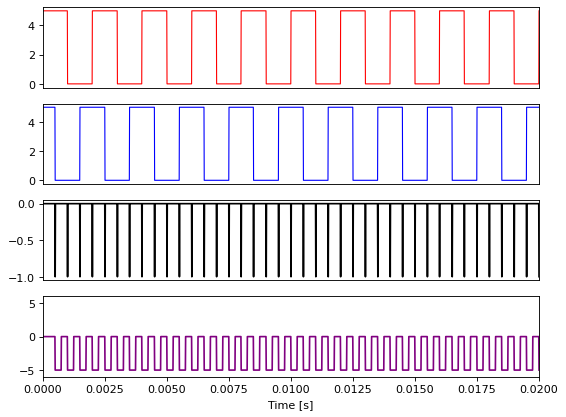

In [181]:
fig, ax = plt.subplots(4,1,figsize=(8, 6), dpi=80)
ax[0].plot(t, dA, lw=1.0, color='red')
ax[1].plot(t, dB, lw=1.0, color='blue')
ax[2].plot(t, d_direction, color='black')
ax[3].plot(t, d_quad, color = 'purple')

ax[0].set_xlim(0, 0.02)
ax[1].set_xlim(0, 0.02)
ax[2].set_xlim(0, 0.02)
ax[3].set_xlim(0, 0.02)
ax[3].set_xlabel("Time [s]")
ax[3].set_ylim(-6, 6)

ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_xticks([])

print(count)

In [ ]:
%%time

count = np.zeros(300)
i = 0
for chunk in df_data:
    t = chunk['t'].to_numpy(copy=False)
    #print(t[0],t[-1])
    dA = chunk['A'].to_numpy(copy=False)
    dB = chunk['B'].to_numpy(copy=False)
    #
    d_direction = gen_pulse_direction(dA, dB, threshold=THRESHOLD_DEFAULT)
    count[i] = pulse_count(d_direction)
    i += 1
    d_quad = gen_quad_pulse(t, d_direction, 0.00025, 5, 100_000)

    #del chunk
    #del t
    #del dA
    #del dB

CPU times: total: 6.09 s
Wall time: 7.59 s


In [183]:
count

array([-400., -400., -400., -400., -400., -400., -400., -400., -400.,
       -400., -400., -400., -400., -400., -400., -400., -400., -400.,
       -400., -400., -400., -400., -400., -400., -400., -400., -400.,
       -400., -400., -400., -400., -400., -400., -400., -400., -400.,
       -400., -400., -400., -400., -400., -400., -400., -400., -400.,
       -400., -400., -400., -400., -400., -400., -400., -400., -400.,
       -400., -400., -400., -400., -400., -400., -400., -400., -400.,
       -400., -400., -400., -400., -400., -400., -400., -400., -400.,
       -400., -400., -400., -400., -400., -400., -400., -400., -400.,
       -400., -400., -400., -400., -400., -400., -400., -400., -400.,
       -400., -400., -400., -400., -400., -400., -400., -400., -400.,
       -400., -400., -400., -400., -400., -400., -400., -400., -400.,
       -400., -400., -400., -400., -400., -400., -400., -400., -400.,
       -400., -400., -400., -400., -400., -400., -400., -400., -400.,
       -400., -400.,

NameError: name 't' is not defined

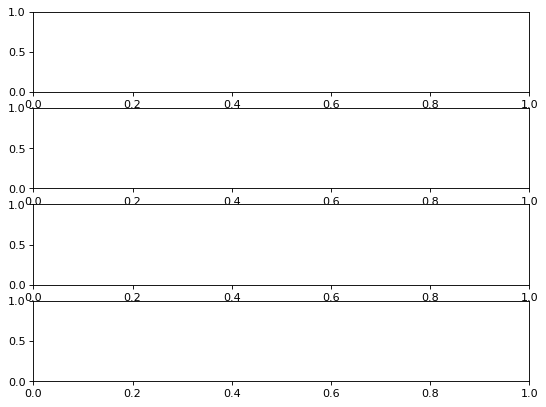

In [185]:
fig, ax = plt.subplots(4,1,figsize=(8, 6), dpi=80)
ax[0].plot(t, dA, lw=1.0, color='red')
ax[1].plot(t, dB, lw=1.0, color='blue')
ax[2].plot(t, d_direction, color='black')
ax[3].plot(t, d_quad, color = 'purple')

ax[0].set_xlim(59.8, 59.82)
ax[1].set_xlim(59.8, 59.82)
ax[2].set_xlim(59.8, 59.82)
ax[3].set_xlim(59.8, 59.82)
ax[3].set_xlabel("Time [s]")
ax[3].set_ylim(-6, 6)

ax[0].set_xticks([])
ax[1].set_xticks([])
ax[2].set_xticks([])

In [ ]:
7.72/300*1000 #200 ms = 0.2 sに対して1/10

25.733333333333334